In [1]:
import texfig
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import t3f
tf.set_random_seed(0)
np.random.seed(0)
%matplotlib inline
import matplotlib.pyplot as plt
import metric_util as mt
import data_util as du
from t3f import shapes
from nilearn import image
from tensorflow.python.util import nest
import copy
from nilearn import plotting
from t3f import ops
import mri_draw_utils as mrd
from t3f import initializers
from t3f import approximate
from scipy import optimize 
from nilearn.masking import compute_background_mask
from nilearn.masking import compute_epi_mask
from collections import OrderedDict
import pandas as pd
from scipy import stats
from nilearn.image import math_img
from t3f import initializers
import numpy.testing as nps
from dipy.sims.voxel import add_noise
import nibabel as nib
import noise_util as nu
import draw_utils as dr
import os

In [2]:
subject_scan_path = du.get_full_path_subject1()
print "Subject Path: " + str(subject_scan_path)
x_true_org = mt.read_image_abs_path(subject_scan_path)
ground_truth = np.array(x_true_org.get_data()).astype('float32')
ten_ones = np.ones_like(ground_truth).astype('float32')
ten_zeros = np.zeros_like(ground_truth).astype('float32')

Subject Path: /work/pl/sch/analysis/data/COBRE001/swaAMAYER+cobre01_63001+M87100944+20110309at135133+RSTpre_V01_R01+CM.nii


In [3]:
def init_random(x):
    init = (2*np.random.random_sample(x.shape) - 1).astype('float32')
    return init

In [4]:
def cost_with_treshold(x, thresh = 0.000212633):
    res = tf.abs(t3f.full(x))
    zeros = tf.zeros_like(res)
    masked = tf.greater(res, thresh)
    new_tensor = tf.where(masked, t3f.full(x), zeros)
    return t3f.to_tt_tensor(new_tensor, max_tt_rank=63)

In [5]:
#Initialize variables

In [6]:
x_init = copy.deepcopy(ground_truth)
x_init_bk = copy.deepcopy(x_init)
norm_ground_x_init = np.linalg.norm(x_init)
x_init = x_init * (1./norm_ground_x_init)
x_init_img = mt.reconstruct_image_affine(x_true_org, x_init)
signal_w_noise = nu.add_richian_noise(x_init_img, x_init, 30)
signal_w_noise_img = mt.reconstruct_image_affine(x_true_org, signal_w_noise)
norm_ground_noise = np.linalg.norm(signal_w_noise)
signal_w_noise = signal_w_noise * (1./norm_ground_noise)
x_init = signal_w_noise.astype('float32')
#tf_ten_zeros = t3f.to_tt_tensor(ten_zeros, max_tt_rank=63)
#tf_ten_ones = t3f.to_tt_tensor(ten_ones, max_tt_rank=63)

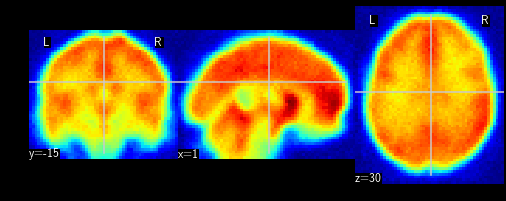

In [7]:
x_hat_img = mt.reconstruct_image_affine(x_true_org, signal_w_noise)
x_hat = image.index_img(x_hat_img,1)
recovered_image = plotting.plot_epi(x_hat, bg_img=None,black_bg=True, cmap='jet', cut_coords=None)

In [8]:
ground_truth_tf = t3f.to_tt_tensor(x_init, max_tt_rank=63)
#tf_zeros = t3f.get_variable('tf_zeros', initializer=tf_ten_zeros, trainable=False)
#tf_ones = t3f.get_variable('tf_ones', initializer=tf_ten_ones, trainable=False)
X = t3f.get_variable('X', initializer=ground_truth_tf, trainable=False)
L = t3f.get_variable('L', initializer=ground_truth_tf)
s_init = init_random(x_init)
s_init.fill(0)
s_init_tf = t3f.to_tt_tensor(s_init, max_tt_rank=63)
S = t3f.get_variable('S',initializer=s_init_tf)

#Sold = t3f.get_variable('Sold', initializer=tf_ten_zeros)
#G = t3f.get_variable('G', initializer=tf_ten_zeros)


[1, 53, 1, 1, 1] 0 (1, 53, 53)
[1, 53, 63, 1, 1] 1 (53, 63, 63)
[1, 53, 63, 63, 1] 2 (63, 46, 63)
ranks: [1, 53, 63, 63, 1]
[1, 53, 1, 1, 1] 0 (1, 53, 53)
[1, 53, 63, 1, 1] 1 (53, 63, 63)
[1, 53, 63, 63, 1] 2 (63, 46, 63)
ranks: [1, 53, 63, 63, 1]


In [9]:
print S
#Initialize Gradienst

A Tensor Train variable of shape (53, 63, 46, 144), TT-ranks: (1, 53, 63, 63, 1)


In [10]:
zero1 = np.array([1.0])
zero1

array([1.])

In [11]:
alpha = 0.01
mu = 0.3

gradSt3f = cost_with_treshold(X - L)
rimGradS = t3f.riemannian.project(gradSt3f,S)
#train_step_tensor_s = t3f.assign(S, gradSt3f)
train_step_tensor_s = gradSt3f
gradLt3f = 1.0/(1.0 + mu)*(X - train_step_tensor_s)
rimGradL = t3f.riemannian.project(gradLt3f,L)
train_step_tensor_l = t3f.assign(L, t3f.round(L + alpha * rimGradL, max_tt_rank=63))
low_rank_update_op = t3f.assign(S, t3f.round(X - train_step_tensor_l,  max_tt_rank=63))
normGradS = t3f.frobenius_norm(rimGradS)
normGradL = t3f.frobenius_norm(rimGradL)
total_grad = rimGradS + rimGradL
total_grad_norm = t3f.frobenius_norm(total_grad)



[1, 53, 1, 1, 1] 0 (1, 53, 53)
[1, 53, 63, 1, 1] 1 (53, 63, 63)
[1, 53, 63, 63, 1] 2 (63, 46, 63)
ranks: [1, 53, 63, 63, 1]
Max_TT rank63
[1, 53, 63, 63, 1]
Max_TT rank63
[1, 53, 63, 63, 1]


In [12]:
loss = 0.5 * t3f.frobenius_norm_squared(L + S - X)
normL_S = t3f.frobenius_norm(L + S - X)

In [13]:
def solution_stopping_criterion(ll,ss,xx):
    return (np.linalg.norm(ll + ss - xx)**2)/(np.linalg.norm(xx)**2)

In [14]:
def relative_convergence_error(solution, k):
    return np.linalg.norm(solution[k] - solution[k-1])/np.linalg.norm(solution[k-1])

In [15]:
solution_S = []
solution_L = []
solution_L_S = []

cost_S = []
cost_L = []

In [16]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [17]:
for i in range (5):
    S_val, norm_gradS_val,loss_val, L_val, norm_gradL_val, normL_S_val,total_grad_norm_val,_,_,_ = sess.run([t3f.full(S), normGradS, loss, t3f.full(L), normGradL, normL_S, total_grad_norm, train_step_tensor_s.op, train_step_tensor_l.op, low_rank_update_op.op])
    #loss_val, L_val, norm_gradL_val, normL_S_val,_ = sess.run([loss, t3f.full(L), normGradL, normL_S, train_step_tensor_l.op])
    print "Iteration#: " + str(i) + "; loss: " + str(loss_val) + "; norm_gradL: " + str(norm_gradL_val) + "; norm_gradS: " + str(norm_gradS_val)
    print "Residual Norm: " + str(normL_S_val)
    print "Gradient Norm: " + str(total_grad_norm_val)
    solution_S.append(S_val)
    solution_L.append(L_val)
    solution_L_S.append(normL_S_val)
    
    solution_tolerance = solution_stopping_criterion(L_val, S_val, x_init)
    
    if i >= 1:
        cost_s_sol = relative_convergence_error(solution_S, i)
        cost_l_sol = relative_convergence_error(solution_L, i)
        cost_ls_sol = relative_convergence_error(solution_L_S, i)
        print "S Relative Error: " + str(cost_s_sol) + "; L Relative Error: " + str(cost_l_sol)
        print "Total Solution Relative Error: " + str(cost_ls_sol)
        
    print "Solution Tolerance: " + str(solution_tolerance)
        
    

Iteration#: 0; loss: 3.5468642e-11; norm_gradL: 0.76903325; norm_gradS: 0.0031622776
Residual Norm: 0.0031622888
Gradient Norm: 0.7690353
Solution Tolerance: 0.000533050515742837
Iteration#: 1; loss: 1.9423438e-10; norm_gradL: 0.7690327; norm_gradS: 0.0031622776
Residual Norm: 0.003162339
Gradient Norm: 0.76903415


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  


S Relative Error: inf; L Relative Error: 0.0076920874
Total Solution Relative Error: 1.5903486e-05
Solution Tolerance: 0.0005330495695051332
Iteration#: 2; loss: 1.8349072e-10; norm_gradL: 0.76903266; norm_gradS: 0.0031622776
Residual Norm: 0.0031623356
Gradient Norm: 0.7690348
S Relative Error: 0.9991572; L Relative Error: 0.00763442
Total Solution Relative Error: 1.1043912e-06
Solution Tolerance: 0.0005330495695051332
Iteration#: 3; loss: 2.124888e-10; norm_gradL: 0.7690337; norm_gradS: 0.0031622776
Residual Norm: 0.0031623447
Gradient Norm: 0.7690349
S Relative Error: 0.49974966; L Relative Error: 0.007576199
Total Solution Relative Error: 2.8714205e-06
Solution Tolerance: 0.0005330497415482896
Iteration#: 4; loss: 2.2698508e-10; norm_gradL: 0.769033; norm_gradS: 0.0031622776
Residual Norm: 0.0031623493
Gradient Norm: 0.76903427
S Relative Error: 0.33326358; L Relative Error: 0.0075193867
Total Solution Relative Error: 1.4725191e-06
Solution Tolerance: 0.000533049655526708


In [18]:
G = x_init - L_val - S_val

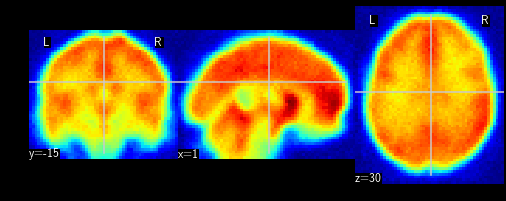

In [19]:
x_hat_img = mt.reconstruct_image_affine(x_true_org, x_init)
x_hat = image.index_img(x_hat_img,1)
recovered_image = plotting.plot_epi(x_hat, bg_img=None,black_bg=True, cmap='jet', cut_coords=None)

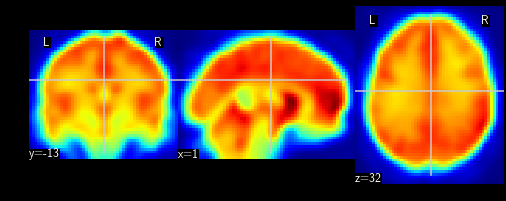

In [20]:
x_hat_img = mt.reconstruct_image_affine(x_true_org, x_init_bk)
x_hat = image.index_img(x_hat_img,1)
recovered_image = plotting.plot_epi(x_hat, bg_img=None,black_bg=True, cmap='jet', cut_coords=None)

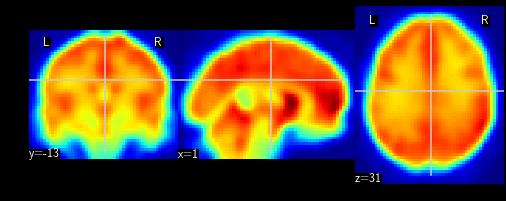

In [30]:
x_hat_img_l = mt.reconstruct_image_affine(x_true_org, L_val)
x_hat = image.index_img(x_hat_img_l,1)
recovered_image = plotting.plot_epi(x_hat, bg_img=None,black_bg=True, cmap='jet', cut_coords=None)

In [22]:
diff_img =  x_init - S_val

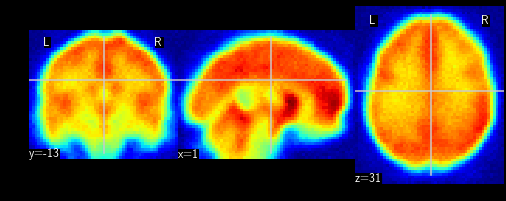

In [23]:
x_hat_img = mt.reconstruct_image_affine(x_true_org, diff_img)
x_hat = image.index_img(x_hat_img,1)
recovered_image = plotting.plot_epi(x_hat, bg_img=None,black_bg=True, cmap='jet', cut_coords=None)

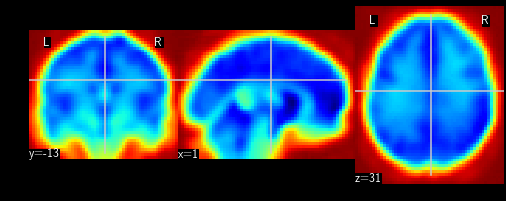

In [24]:
x_hat_img = mt.reconstruct_image_affine(x_true_org, S_val)
x_hat = image.index_img(x_hat_img,1)
recovered_image = plotting.plot_epi(x_hat, bg_img=None,black_bg=True, cmap='jet', cut_coords=None)

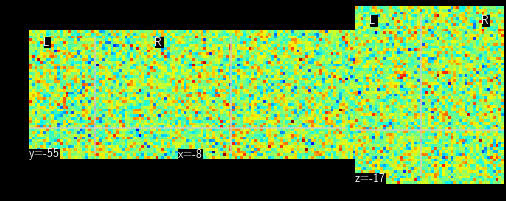

In [25]:
x_hat_img = mt.reconstruct_image_affine(x_true_org, G)
x_hat = image.index_img(x_hat_img,1)
recovered_image = plotting.plot_epi(x_hat, bg_img=None,black_bg=True, cmap='jet', cut_coords=None)

In [80]:
def save_fig_pdf(fig_id, tight_layout=True):
        path_pdf = os.path.join(fig_id + ".pdf")
        print("Saving figure", path_pdf)
        print("Called from draw utils")
        plt.savefig(path_pdf, format='pdf', facecolor='k', edgecolor='k', dpi=1000)
        plt.close()

In [65]:
tex_width = 4.78853 # in inches

In [81]:
def draw_image1(img, folder, fig_id, plot_title):
    
    fig = plt.figure(frameon = False)
    
    plt.clf()
    ax = plt.gca()
    fig, (main_ax, ax1, ax2) = plt.subplots(width=tex_width, pad = 0, nrows=1, ncols=3, sharex=True, sharey=False)
    main_ax.set_facecolor("blue")
    main_ax.set_title('Noise Free fMRI Images', color=fg_color, fontweight='normal', fontsize=8)  
    main_ax.set_aspect('equal')
    
    scan_image = plotting.plot_epi(img, annotate=True, draw_cross=False, bg_img=None,black_bg=True, figure= fig, axes = main_ax, cmap='jet', cut_coords=1)     
    
    fg_color = 'white'
    bg_color = 'black'
   
    fig.suptitle(plot_title, color=fg_color, fontweight='normal', fontsize=10)
      
    fig_path = os.path.join(folder, fig_id)
    
    print ("Figure Path: " + fig_path)
    
    save_fig_pdf(fig_path)

In [34]:
folder = "/work/scratch/alternate_minimation/richian/run_2018-12-05_22_38_47/d4/richian/images"

In [40]:
fig_id = "x_low_rank_" + "snr_" + str(30) + "_" + str("Richian1")

In [61]:
title = "fMRI Denoising" + " SNR = " + str(30) + " Noise Type: " + "Richian"

In [83]:

draw_image1(image.index_img(x_hat_img_l,1), folder, fig_id, title)

Figure Path: /work/scratch/alternate_minimation/richian/run_2018-12-05_22_38_47/d4/richian/images/x_low_rank_snr_30_Richian1
('Saving figure', '/work/scratch/alternate_minimation/richian/run_2018-12-05_22_38_47/d4/richian/images/x_low_rank_snr_30_Richian1.pdf')
Called from draw utils


In [26]:
solution_tolerance = solution_stopping_criterion(L_val, S_val, x_init)

In [27]:
solution_tolerance

0.000533049655526708

In [28]:
total = S_val + L_val + G

In [29]:
total

array([[[[1.79876915e-05, 9.28705049e-06, 1.27394051e-05, ...,
          8.82795212e-06, 1.07621745e-05, 1.06715379e-05],
         [2.02137835e-05, 1.23802347e-05, 3.19343962e-06, ...,
          1.13893620e-05, 1.16920637e-05, 1.63600853e-05],
         [1.35905757e-05, 1.56459755e-05, 6.33018135e-06, ...,
          1.10574219e-05, 1.46361199e-05, 8.18510671e-06],
         ...,
         [6.68377470e-06, 3.47195783e-06, 1.21519624e-05, ...,
          5.15978536e-06, 8.12777216e-06, 1.09182620e-05],
         [1.33974481e-05, 5.23484050e-06, 6.91266177e-06, ...,
          6.77533171e-06, 1.21211815e-06, 9.99104304e-06],
         [2.25280019e-06, 4.72332977e-06, 4.58635805e-06, ...,
          5.69812255e-06, 5.34875653e-06, 7.10340828e-06]],

        [[9.87520980e-06, 3.01999171e-06, 1.75129317e-05, ...,
          5.65948721e-06, 1.02645718e-05, 1.33849135e-05],
         [1.39898730e-05, 1.13581555e-05, 1.37293064e-05, ...,
          1.20634541e-05, 1.64811972e-05, 1.36685740e-05],
        

In [48]:
nps.assert_allclose(total, x_init, rtol=1e-4, atol=0)

In [ ]:
from skimage.util import random_noise

In [ ]:
noisy = random_noise(x_init, var=0.01)

In [ ]:
noise = np.random.normal(0, 1, x_init.shape)

In [ ]:
noisy = x_init + noise

In [ ]:
from dipy.sims.voxel import add_noise
from dipy.denoise.noise_estimate import estimate_sigma

In [ ]:
sigma = estimate_sigma(noisy, N=1)

In [ ]:
from dipy.denoise.nlmeans import nlmeans
den = nlmeans(noisy, sigma=sigma, patch_radius= 1, block_radius = 1, rician= False)

In [ ]:
mask_img = compute_epi_mask(x_true_org)
mask_img_data = np.array(mask_img.get_data())

In [ ]:
import noise_util

In [ ]:
from dipy.sims.voxel import add_noise

In [ ]:
x_init_copy = copy.deepcopy(x_init)

In [ ]:
signal_w_noise = add_noise(x_init_copy, 100000, 1, noise_type='rician')
norm_ground_noise = np.linalg.norm(signal_w_noise)
signal_w_noise = signal_w_noise * (1./norm_ground_noise)
x_hat_img = mt.reconstruct_image_affine(x_true_org, signal_w_noise)
x_hat = image.index_img(x_hat_img,1)
recovered_image = plotting.plot_epi(x_hat, bg_img=None,black_bg=True, cmap='jet', cut_coords=None)

In [ ]:
noise_img = mt.reconstruct_image_affine(x_true_org, x_init)

In [ ]:
nib.save(noise_img, 'noise_img.nii')

In [ ]:
#dipy.sims.voxel.add_noise(signal, snr, S0, noise_type='rician')

recovered_image = mt.reconstruct_image_affine(x_true_org, L_val)
nib.save(recovered_image, 'low-rank-img.nii')

In [2]:
from nipype.algorithms import confounds as nac

In [ ]:
tsnr = nac.TSNR()
tsnr.inputs.in_file = 'low-rank-img.nii'
res = tsnr.run()
   

In [17]:
tsnr_image_data.shape

(53, 63, 46)

In [15]:
tsnr_path = 'tsnr.nii.gz'
tsnr_image = mt.read_image_abs_path(tsnr_path)
tsnr_image_data = np.array(tsnr_image.get_data())

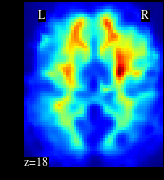

In [24]:
tsnr_img = mt.reconstruct_image_affine(x_true_org, tsnr_image_data)
recovered_image = plotting.plot_epi(tsnr_img, bg_img=None,black_bg=True, display_mode='z', cmap='jet', cut_coords = [18])

In [ ]:
mean_path = 'mean.nii.gz'
mean_image = mt.read_image_abs_path(mean_path)
mean_image_data = np.array(mean_image.get_data())

In [ ]:
x_hat_img = mt.reconstruct_image_affine(x_true_org, mean_image_data)
recovered_image = plotting.plot_epi(x_hat_img, bg_img=None,black_bg=True, display_mode='z', cmap='jet', cut_coords = 3)

In [ ]:
stdev_path = 'stdev.nii.gz'
stdev_image = mt.read_image_abs_path(stdev_path)
stdev_image_data = np.array(stdev_image.get_data())

In [ ]:
x_hat_img = mt.reconstruct_image_affine(x_true_org, stdev_image_data)
recovered_image = plotting.plot_epi(x_hat_img, bg_img=None,black_bg=True, display_mode='z', cmap='jet', cut_coords = 3)

In [11]:
tsnr = nac.TSNR()
tsnr.inputs.in_file = subject_scan_path
res = tsnr.run()

In [14]:
stdev_image_data.shape

(53, 63, 46)

In [12]:
stdev_path = 'stdev.nii.gz'
stdev_image = mt.read_image_abs_path(stdev_path)
stdev_image_data = np.array(stdev_image.get_data())

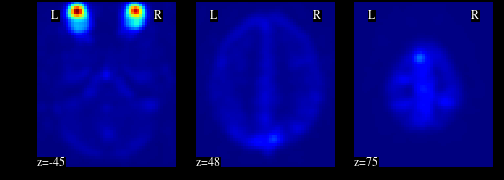

In [13]:
x_hat_img = mt.reconstruct_image_affine(x_true_org, stdev_image_data)
recovered_image = plotting.plot_epi(x_hat_img, bg_img=None,black_bg=True, display_mode='z', cmap='jet', cut_coords = [3])

In [ ]:
mask_img = compute_epi_mask(x_true_org)

In [ ]:
nib.save(mask_img, 'epi_mask.nii')

In [ ]:
dvars = nac.ComputeDVARS()

In [ ]:
dvars.inputs.in_file = subject_scan_path
dvars.inputs.in_mask = 'epi_mask.nii'
dvars.inputs.save_all = True
dvars.inputs.save_plot = True
dvars.inputs.figformat = 'pdf'
dvars.run()

In [ ]:
dvars.inputs.in_file = 'low-rank-img.nii'
dvars.inputs.in_mask = 'epi_mask.nii'
dvars.inputs.save_all = True
dvars.inputs.save_plot = True
dvars.inputs.figformat = 'pdf'
dvars.run()

In [ ]:
comp_corr = nac.CompCor()
comp_corr.inputs.realigned_file = subject_scan_path
comp_corr.run()